# Interactive visualization homework overview
In this homework, we want to make an interactive visualization of the grants received from the SNSF in each canton. The data is the P3 data given on the [SNSF website](http://p3.snf.ch/), called P3_GrantExport.csv
To do so, 
* we first load the data with pandas;
* we only keep the columns of interest (University name, Institution name, amount of money received for each project, start and end dates of the project);
* and we only keep the rows of interest (corresponding to Swiss universities, that is any non-nan "University" entry is valid), being careful with nan values.
* Then, we have to map the universities to their corresponding cantons using [Geonames Full Text Search API in JSON](http://www.geonames.org/export/web-services.html) together with some manual tuning. 
* We finally visualize the results thanks to folium on the map of Switzerland, using a cloropleth map.

## Import librarires and load data

In [1]:
import pandas as pd
import numpy as np
import folium
import requests
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Read the csv file with the separator ; and create a dataframe from it.

In [2]:
data = pd.read_csv('P3_GrantExport.csv',sep=';')
data = data.rename(columns={'\ufeff"Project Number"':'Project','Approved Amount':'Amount'})
data = data.set_index('Project')

We check if the project number is actually a unique identifier, as declared in the SNSF P3 website.

In [3]:
data.index.is_unique

True

Since it is unique, we set it as the index of the dataframe. We explore now the dataframe parameters, in order to understand which of them are interesting for our purposes:

In [4]:
data.columns

Index(['Project Title', 'Project Title English', 'Responsible Applicant',
       'Funding Instrument', 'Funding Instrument Hierarchy', 'Institution',
       'University', 'Discipline Number', 'Discipline Name',
       'Discipline Name Hierarchy', 'Start Date', 'End Date', 'Amount',
       'Keywords'],
      dtype='object')

## Choose data of interest
A complete description of the parameters can be found at http://p3.snf.ch/Pages/DataAndDocumentation.aspx. The attributes which are interesting for us are:

* 'Institution': place where the project is carried out
* 'University': academic insitution where the project is carried out
* 'Approved Amount': grant for the project (CHF)

We keep in also the 'Start Date' and the 'End date' parameters for eventual further investigations which take time into account.
Let us filter the dataset now.

In [5]:
data = data[['Institution','University','Amount','Start Date','End Date']]
data.head()

,Institution,University,Amount,Start Date,End Date
Project,,,,,
1,NaN,Nicht zuteilbar - NA,11619.00,01.10.1975,30.09.1976
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.00,01.10.1975,30.09.1976
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00,01.03.1976,28.02.1985
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.00,01.10.1975,30.09.1976
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00,01.01.1976,30.04.1978


# Preliminar data exploration
In this section we will explore the essential features of the dataset to learn better how it looks like.
We know a priori the structure of the dataset, and in particular, we have seen that some University fields are filled with NaN, while other columns contain some specific string, such as "Nicht zuteilbar - NA", that is, 'not allocable'. Moreover, when the grant amount is not given, one can find the specification "data not included in P3". These data arise actually from projects developed at foreign Universities, as said in the documentation of P3. Consequently, they are not interesting for our study. It is thus reasonable to drop them out of the dataset.

Let us study first the 'University' field.

In [6]:
# String of missing data
nan_string1 = 'Nicht zuteilbar - NA'
# Compute the amount of NaN
data = data.replace(nan_string1, np.nan)
nans_uni = data['University'].isnull().value_counts()

print(str(nans_uni[True]/nans_uni.sum())+' is the ratio of NaN values out of '+str(nans_uni.sum())+' projects.')

0.243492941894 is the ratio of NaN values out of 63969 projects.


There are roughly **24%** of NaN values in the field 'University', that is, around a fourth of the projects are developed in non Swiss Universities.

Now, let us study the 'Amount' field. We convert the grant amounts from string to floating point numbers, in order to treat them quantitatively.

In [7]:
# String of missing data
nan_string2 = 'data not included in P3'
# Amount of NaN
data = data.replace(nan_string2, np.nan)
nans_amount = data['Amount'].isnull().value_counts()

print(str(nans_amount[True]/nans_amount.sum())+' is the ratio of NaN values out of '+str(nans_amount.sum())+' projects.')

0.170551360815 is the ratio of NaN values out of 63969 projects.


The percentage of invalid grants data is about **17%**.

We will now convert the date fields from strings into datetime format, in order to better process them and link the grants to their temporal evolution.

In [8]:
data['Start Date'] = pd.to_datetime(data['Start Date'], format="'%d.%m.%y'",errors='ignore')
data['End Date'] = pd.to_datetime(data['End Date'], format="'%d.%m.%y'",errors='ignore')

In [9]:
data[data['Start Date'].isnull() | data['End Date'].isnull()]

,Institution,University,Amount,Start Date,End Date
Project,,,,,
35737,NaN,Universität Zürich - ZH,46230.00,NaN,NaN


Notice that there is one NaN value in the data 'Start Date' and 'End Date' entry (Project Number: 35737). We do not want to wipe it out, since there are informations concerning both the grant and the University.

Now we drop the NaNs out of the dataset and visualize the resulting distribution of grants in time:

In [10]:
len_data = len(data)
data = data[~data.Amount.isnull()]
data = data[data.Institution.notnull() | data.University.notnull()]

In [11]:
print('Percentage of removed data: ' + str(1-len(data)/len_data) )
data['Amount'] = data['Amount'].astype(float)

Percentage of removed data: 0.22113836389501162


We now plot the data over time, that is the amount of grants in function of the start time of the projects, together with the statistical distribution. 

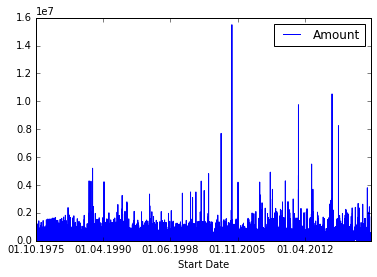

In [12]:
data[~data['Start Date'].isnull()].plot(x='Start Date',y='Amount')

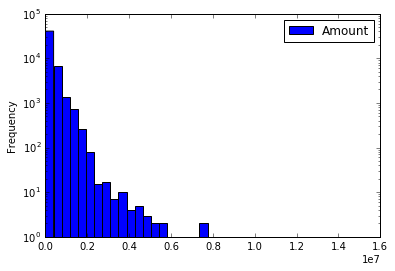

In [13]:
data.plot(x='Start Date',y='Amount',kind='hist',logy=True,bins=40)
df = data

The distribution of the dataset seems not to follow a power law, since the general behaviour is non linear, or it could be only for law values of grants, because of a heavy tail at high values. 

# Outliers identification

We want now to identify the outlier points in the grants amount distribution. Our hypothesis concerning the outliers of the distribution is that the more granted the project, the longer it takes to be carried out. We add a column to the dataset to specify the duration of the project, using the datetime format.

In [15]:
dates = []
for date in data[['Start Date','End Date']].itertuples(index=False):
    dates.append(pd.to_datetime(date[1])-pd.to_datetime(date[0]))

In [16]:
data['Duration'] = dates
data.head()

,Institution,University,Amount,Start Date,End Date,Duration
Project,,,,,,
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0,01.10.1975,30.09.1976,629 days
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985,3344 days
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0,01.10.1975,30.09.1976,629 days
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0,01.01.1976,30.04.1978,850 days
8,"Séminaire de politique économique, d'économie ...",Université de Fribourg - FR,53009.0,01.01.1976,31.12.1978,1095 days


We convert days into int in order to be able to draw plots.

In [17]:
duration = []
for dur in data.Duration:
    if(pd.isnull(dur)):
        duration.append('NaN')
    else:
        duration.append(dur.days)

In [18]:
data['Duration']=duration
data.Duration = data.Duration.astype(float)
data.head()

,Institution,University,Amount,Start Date,End Date,Duration
Project,,,,,,
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0,01.10.1975,30.09.1976,629.0
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985,3344.0
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0,01.10.1975,30.09.1976,629.0
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0,01.01.1976,30.04.1978,850.0
8,"Séminaire de politique économique, d'économie ...",Université de Fribourg - FR,53009.0,01.01.1976,31.12.1978,1095.0


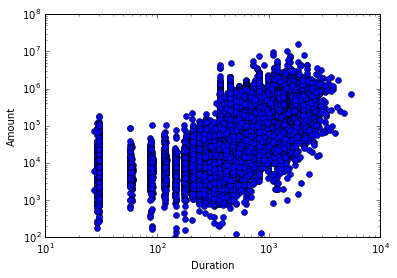

In [19]:
# scatter plot in log-log scale
plt.loglog(data['Duration'], data['Amount'],'o')
plt.xlabel('Duration')
plt.ylabel('Amount')

Our hypothesis seems to be confirmed. Grants and duration are positively correlated, so that highly granted projects do not represent "bad" outliers, but are linked to longer projects.

# From university to canton

In [21]:
df = df[['Institution', 'University', 'Amount']]
print(df.shape)
print(df.dtypes)

(49823, 3)
Institution     object
University      object
Amount         float64
dtype: object


In [22]:
df.head()

,Institution,University,Amount
Project,,,
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0
8,"Séminaire de politique économique, d'économie ...",Université de Fribourg - FR,53009.0


In [23]:
df = df.reset_index()

In [24]:
username = 'deatinor'
url = 'http://api.geonames.org/postalCodeSearchJSON?'

In [25]:
correspondencies_dictionary={'CERN':'GE','Projekte + Ausbildung Soziales Gesundheit Rehabilitation':'ZH',
                            'Psychotherapeutische Abteilung Universitäre Psychiatrische Kliniken UPK':'BS',
                            'Pädagogische Hochschule Fachhochschule Nordwestschweiz, Pädagogische Hochschule Nordwestschweiz - PHFHNW':'BS',
                            'Kalaidos Fachhochschule Departement Gesundheit, Fachhochschule Kalaidos - FHKD':'ZH',
                            'Eawag':'ZH',
                            'Pädagogische Hochschule FHNW, Pädagogische Hochschule Nordwestschweiz - PHFHNW':'BL',
                            'Naturwissenschaftsdidaktik Sekundarstufe Pädagogische Hochschule Fachhochschule Nordwestschweiz, Pädagogische Hochschule Nordwestschweiz - PHFHNW':'BL',
                            'Forschungsgruppe Sozioökonomie Forschungsbereich Agrarökonomie Agroscope':'VD',
                            'Departement Erziehungswissenschaften Universität Freiburg': 'FR',
                            'Eidg. Material und Prüfungsanstalt - EMPA': 'SG',
                            'Fachhochschule Nordwestschweiz (ohne PH) - FHNW': 'SO',
                            'Haute école de santé ARC Haute Ecole Spécialisée de Suisse occidentale':'JU',
                            'HES de Suisse occidentale - HES-SO':'JU',
                            'Haute école de santé ARC Haute Ecole Spécialisée de Suisse occidentale':'JU',
                            'Haute école pédagogique BE, JU, NE - HEPBEJUNE': 'JU',
                            "IHEID Fondation pour l'institut de hautes études internationales et du développement": 'GE',
                            'Idiap Research Institute - IDIAP': 'VS',
                            'Inst. Suisse de Spéléologie et Karstologie - ISSKA': 'JU',
                            'Inst. de Hautes Etudes Internat. et du Dév - IHEID': 'GE',
                            'Institut de physique de la matière condensée EPFL - SB - ICMP': 'VD', 
                            'Laboratoire de Neurologie et Imagerie de la Cognition Dépt. de Neurosciences Fondamentales': 'GE',
                            'Laboratoire de physique de la matière vivante EPFL - SB - IPSB - LPMV': 'VD',
                            'Schweiz. Institut für Kunstwissenschaft - SIK-ISEA': 'ZH',
                            'Station fédérale de recherches agronomiques de Changins': 'VD',
                            'Università della Svizzera italiana - USI': 'TI',
                            }

In [26]:
reject_list=['Firmen/Privatwirtschaft - FP',
            'Institut für Physikalische Chemie Universität Freiburg',
            'NPO (Biblioth., Museen, Verwalt.) - NPO',
            'Nicht zuteilbar - NA',
            "UMR 6578 CNRS Unité d'anthropologie Faculté de Médecine Université de la Méditerranée",
            'UNI: Centre de Recherche sur les Maladies Au toimmune Groupe Hospitalier Necker Paris F',
            'UNI: Heriott-Watt University Department of M athematics Riccarton Edinburgh GB',
            'UNI: IMAGE et VILLE Institut de Géographie Strasbourg F',
            'UNI: University of East Anglia Climatic Rese arch Unit  Norwich GB',
            'Weitere Institute - FINST',
            'Weitere Spitäler - ASPIT'
            ]

In [27]:
params={'username':username,'placename':'CH','maxRows':1,'operator':'OR'}
r=requests.get(url,params=params)

In [28]:
i=0
df_final=pd.DataFrame({'Name':[],'Canton':[],'Amount':[]})
not_found_list=[]
for block in df[['Institution','University','Amount']].itertuples(index=False):
    nan1=str(block[0])
    nan2=str(block[1])
    amount=block[2]
    
    # By default take only the university.
    # The first time a value is added it is checked for differences if adding also the institution.
    if nan1=='nan':
        if nan2=='nan':
            raise('Bad preprocessing - double nan')
        query_string=block[1]
    elif nan2=='nan':
        query_string=block[0]
    else:
        query_string=block[0]+", "+block[1]
    
    
    # List of checks if already present in the dictionary:
    # 1- institution + university 
    # 2- university 
    # 3- query to geonames
    try:
        if query_string in reject_list:
            #print(query_string)
            continue
        canton=correspondencies_dictionary[query_string]
        df2=pd.DataFrame({'Name':[query_string],'Canton':[canton],'Amount':[amount]})
        df_final=df_final.append(df2)
    except:
        try:
            query_string_university=str(block[1])
            if query_string_university in reject_list:
                #print(query_string)
                continue
            canton=correspondencies_dictionary[query_string_university]
            df2=pd.DataFrame({'Name':[query_string_university],'Canton':[canton],'Amount':[amount]})
            df_final=df_final.append(df2)
        except:
            try:
                params['placename']=query_string
                r=requests.get(url,params=params)
                df1=pd.read_json(r.text,orient='records')
                canton=df1.postalCodes[0]

                if nan2!='nan':
                    query_string_short=block[1]
                    r=requests.get(url,params=params)
                    df1=pd.read_json(r.text,orient='records')
                    canton2=df1.postalCodes[0]
                    if canton2==canton:
                        query_string=query_string_short
                    else:
                        print(canton2,canton)

                if canton['countryCode']!='CH':
    #                 if nan2!='nan':
    #                     print(2140358234)
    #                 print(query_string)
    #                 print(canton['countryCode'])
                    continue
                df2=pd.DataFrame({'Name':[query_string],'Canton':[canton['adminCode1']],'Amount':[amount]})
                df2=df2.rename(columns={'adminCode1':'Canton'})
                df_final=df_final.append(df2)
                correspondencies_dictionary[query_string]=df2.Canton[0]
            except:
                print(query_string)
                not_found_list.append(query_string)
    i+=1
    
    if i%5000==0:
        print(i)

Regierungsgebäude
Regierungsgebäude
Rotkreuzspital
5000
10000
Thurgauer Namenbuch
Sozialforschung
Istituto storico germanico
15000
Thurgauer Namenbuch
Thurgauer Namenbuch
Thurgauer Namenbuch
Thurgauer Namenbuch
Sozialforschung
DüCo Sozialforschung
20000
Thurgauer Namenbuch
Thurgauer Namenbuch
Thurgauer Namenbuch
25000
Thurgauer Namenbuch
Thurgauer Namenbuch
30000
Thurgauer Namenbuch
Thurgauer Namenbuch
Luzerner Namenbuch
Thurgauer Namenbuch
Luzerner Namenbuch
35000
Thurgauer Namenbuch
40000
45000


In [29]:
df_final.shape

(46139, 3)

In [30]:
len(correspondencies_dictionary)

594

In [31]:
correspondencies_dictionary

{'Abt. Industriegüter- & Technologiemarketing Inst. für Marketing und Unternehmensführung Universität Bern': 'BE',
 'Abt. Ultrastruktur-Pathologie & Zellbiologie Institut für klinische Pathologie Universität Wien': 'LU',
 'Abteilung Biochemie Biozentrum Universität Basel': 'BS',
 'Abteilung Gastroenterologie Departement Klinische Forschung Universität Bern': 'BE',
 'Abteilung Molekulare Pathobiologie Vetsuisse-Fakultät Universität Bern': 'BE',
 'Abteilung Pharmakologie/Neurobiologie Biozentrum der Universität Basel': 'BS',
 'Abteilung Populationsgenetik Institut für Ökologie und Evolution Universität Bern': 'BE',
 'Abteilung c2d Zentrum für Demokratie Aarau Universität Zürich': 'ZH',
 'Abteilung für Sport- und Leistungs- medizin, Medizinische Klinik & Poli klinik, Ruprecht-Karls-Universität': 'LU',
 'Anatomisches Institut Universität Zürich': 'ZH',
 'Anthropologisches Institut und Museum Universität Zürich-Irchel': 'ZH',
 'Architektur und Bauprozess Institut für Technologie in der Arch

In [33]:
df_final['index']=range(df_final.shape[0])
df_final=df_final.set_index(['index'])
df_final.head()

,Amount,Canton,Name
index,,,
0,41022.0,GE,Université de Genève - GE
1,52627.0,BS,Universität Basel - BS
2,53009.0,FR,Université de Fribourg - FR
3,25403.0,FR,Université de Fribourg - FR
4,47100.0,ZH,Universität Zürich - ZH


# Folium visualization

In [34]:
a=df.groupby(df_final.Canton)

In [35]:
df_group=pd.DataFrame({'Canton':[],'Amount':[]})

In [36]:
list_canton=[]
for i,group in a:
    list_canton.append(i)
    s=group['Amount'].sum()
    df_group=df_group.append(pd.DataFrame({'Canton':[i],'Amount':[s]}))
list_canton

['AG',
 'BE',
 'BL',
 'BS',
 'FR',
 'GE',
 'GR',
 'JU',
 'LU',
 'NE',
 'SG',
 'SH',
 'SO',
 'SZ',
 'TG',
 'TI',
 'VD',
 'VS',
 'ZG',
 'ZH']

In [40]:
canton_list=['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']

In [41]:
for i in canton_list:
    isin=df_group.Canton.isin([i]).sum()
    if not isin:
        df_group=df_group.append(pd.DataFrame({'Canton':[i],'Amount':[0]}))

In [43]:
df_group

,Amount,Canton
0,1.117257e+08,AG
0,1.419762e+09,BE
0,7.437700e+05,BL
0,1.228967e+09,BS
0,5.396628e+08,FR
0,1.635246e+09,GE
0,1.562881e+07,GR
0,9.135043e+07,JU
0,1.064055e+08,LU
0,4.133214e+08,NE


In [45]:
map_osm = folium.Map(location=[47, 7])
state_geo = r'ch-cantons.topojson.json'
map_osm.choropleth(geo_path=state_geo,key_on='feature.id',topojson='objects.cantons',data=df_group,
                   columns=['Canton','Amount'],fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                  legend_name='Total grants per canton',
                  threshold_scale=[1e05, 1e06, 1e07, 1e08, 1e09,2e09],)
map_osm.save('map.html')

# Bonus

In [46]:
french_cantons=['GE','JU','NE','VD']

In [47]:
italian_cantons=['TI']

Bern is mostly german, we considered it as german since most of the projects are in the german-speaking city of Bern
The Grisons canton is considered a german-speaking canton.
The money given to this canton are not so much compared to the others so the estimate is reasonable.

In [48]:
both_cantons=['FR','VS']

In [49]:
french_money=0
german_money=0
for block in df_group[['Amount','Canton']].itertuples(index=False):
    canton=block[1]
    money=block[0]
    if canton in french_cantons:
        french_money+=money
    elif canton in both_cantons:
        french_money+=money/2
        german_money+=money/2
    elif canton not in italian_cantons:
        german_money+=money

rostigraben_df=pd.DataFrame({'French':[french_money],'German':[german_money]})
rostigraben_df

,French,German
0,4.581291e+09,6.893304e+09


In [51]:
fraction=french_money/(french_money+german_money)
print("The percentage of money given to the French part of Switzerland is "+str(fraction*100)+"%")

The percentage of money given to the French part of Switzerland is 39.9255140529%
